# Unsupervised Mushrooom Classification

This dataset has a 126 features and a single target variable. Using PCA for dimenisonality reduction, I will then use Kmeans clustering and Gaussian Mixture Models to classify the mushrooms as either poisonous or non-poisnonous

## Import

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
# from sklearn.mixture import GMM
from sklearn.mixture import GaussianMixture
from matplotlib.colors import LogNorm
from sklearn import __version__ as sk_version
print sk_version

0.19.2


## Load the data

Load feature names.

In [2]:
feature_names = []
with open('../Data/mushroom.map') as fmap:
    for line in fmap:
        [index, name, junk] = line.split()
        feature_names.append(name)

print 'Loaded feature names:', len(feature_names)

Loaded feature names: 126


Load data. The data is sparse in the input file, but there aren't too many features, so we'll use a dense representation, which is supported by all sklearn objects.

In [3]:
X, Y = [], []

with open('../Data/mushroom.data') as fdata:
    for line in fdata:
        items = line.split()
        Y.append(int(items.pop(0)))
        x = np.zeros(len(feature_names))
        for item in items:
            feature = int(item.split(':')[0])
            x[feature] = 1
        X.append(x)

# Convert these lists to numpy arrays.
X = np.array(X)
Y = np.array(Y)

# Split into train and test data.
train_data, train_labels = X[:7000], Y[:7000]
test_data, test_labels = X[7000:], Y[7000:]

# Check that the shapes look right.
print train_data.shape, test_data.shape

(7000L, 126L) (1124L, 126L)


## PCA dimenisonality reduction

Examine the results of simple PCA dimensionality reduction for [1,50] components

In [4]:
### STUDENT START ###
def P1(n_components=50):
    # setting random_state to ensure consistent results
    pca = PCA(random_state=0)
    
    # fit the training data
    pca.fit(train_data)
    
    # grabbing the explained variance ratio (EVR) for each component
    evr = pca.explained_variance_ratio_
    n = np.arange(1,len(evr)+1)
    
    # display EVR and cumulative EVR for components in [1, n_components]
    df = pd.DataFrame(zip(n, evr, np.cumsum(evr)), columns=[
        'Component',
        'Component Explained Var. Ratio', 
        'Cumulative Explained Var. Ratio'
    ])
    df = df.set_index('Component')
    print df.head(n_components)

P1()
### STUDENT END ###

           Component Explained Var. Ratio  Cumulative Explained Var. Ratio
Component                                                                 
1                                0.164043                         0.164043
2                                0.133235                         0.297278
3                                0.101735                         0.399013
4                                0.070634                         0.469646
5                                0.038666                         0.508313
6                                0.036808                         0.545121
7                                0.031282                         0.576403
8                                0.027337                         0.603741
9                                0.026165                         0.629905
10                               0.022309                         0.652215
11                               0.020482                         0.672697
12                       

## Visualize the PCA dimenisonality reduction

Data projected into 2 dimensions, plotted by label

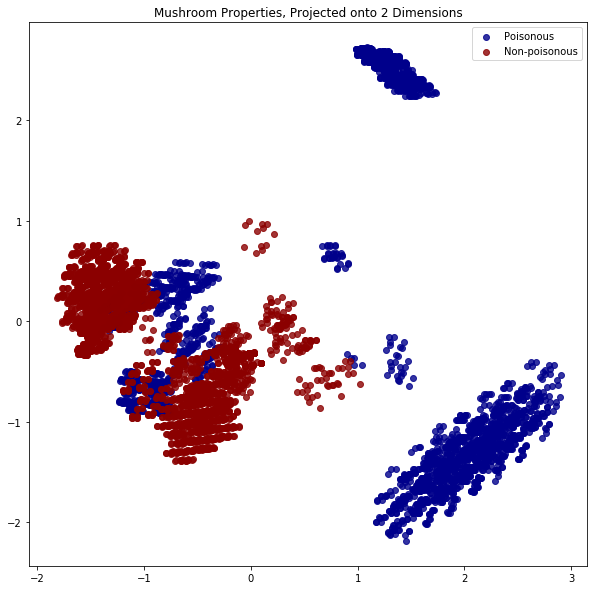

In [5]:
### STUDENT START ###
def P2(data, labels):
    fig = plt.figure(figsize=(10,10))
    
    # setting my number of components to 2 for 2D projection
    pca = PCA(n_components=2, random_state=0)
    
    # Fitting and the training data and projecting into 2 dimensions
    x = pca.fit(data).transform(data)
    y = labels
    
    # Plot the results with 'poisonous' in blue and 'non-poisonous' in 
    # red
    plt.scatter(x[y == 1, 0], x[y == 1, 1], c='darkblue', alpha=0.8)
    plt.scatter(x[y == 0, 0], x[y == 0, 1], c='darkred', alpha=0.8)
    plt.legend(['Poisonous', 'Non-poisonous'])
    plt.title('Mushroom Properties, Projected onto 2 Dimensions')
    
    return x

train_data_2D = P2(train_data, train_labels)
### STUDENT END ###

## Visualize K-means clustering

for k = [1,16], visualize each of k clusters

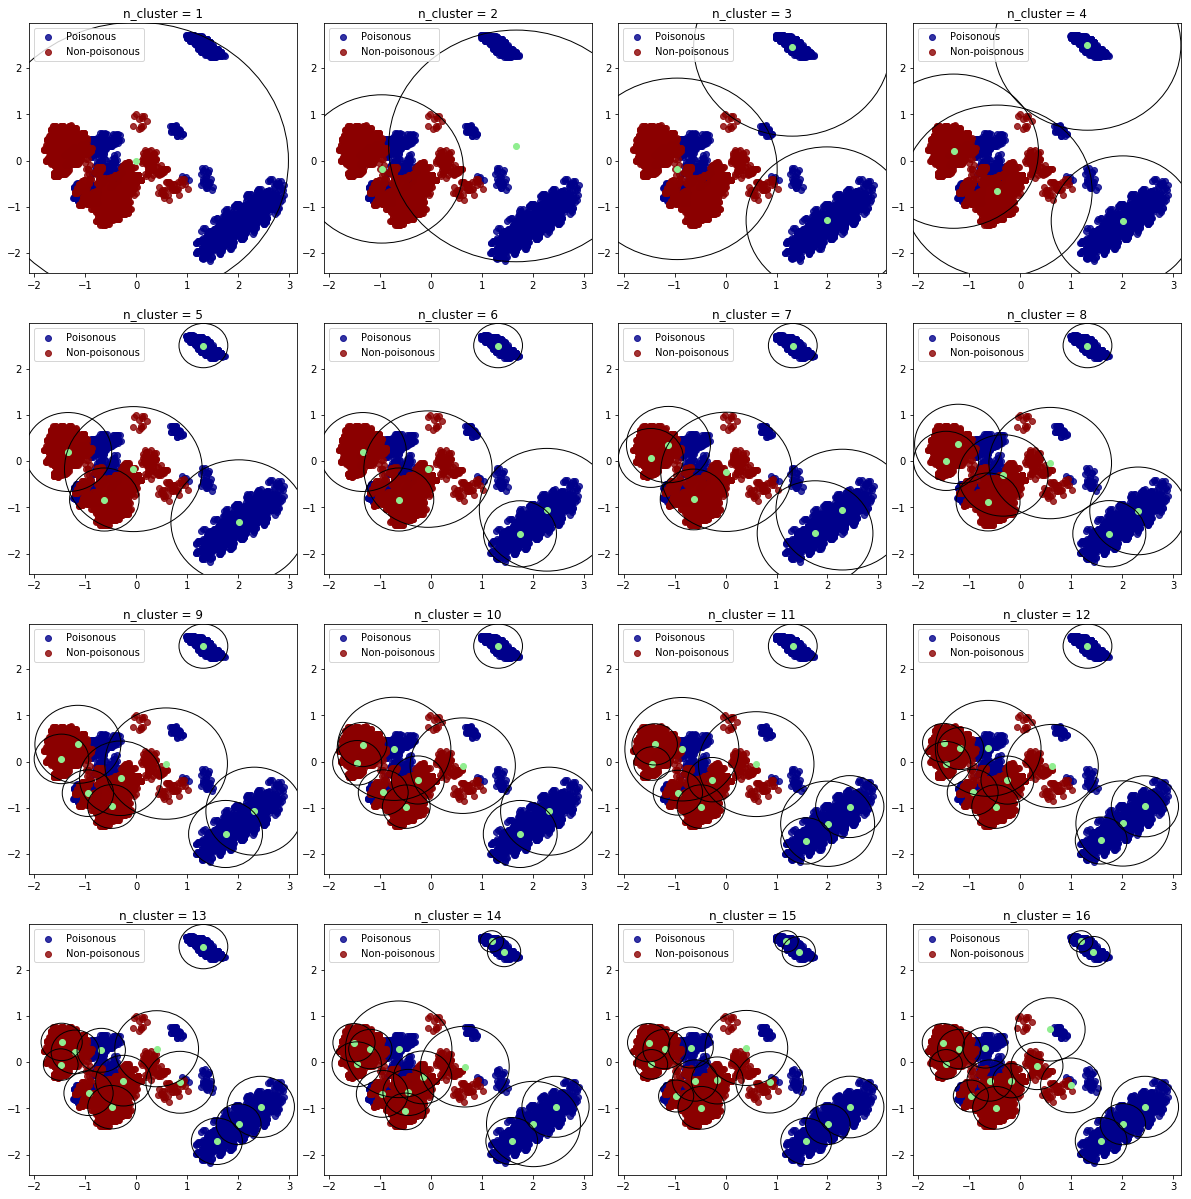

In [6]:
### STUDENT START ###
def calc_cluster_radius(i, data, centroids, labels):
    '''This function calculates the radius of each cluster by finding
    the point that has the largest radial distance from the centroid.
    '''
    # grab the centroid of interest
    centroid = centroids[i]
    
    # find all data points within the corresponding cluster
    sample = data[labels == i, :]
    
    # determine the radial distance of each point
    dx = sample[:,0] - centroid[0]
    dy = sample[:,1] - centroid[1]
    radius = np.sqrt(dx**2 + dy**2)
    
    # return the largest radius
    return np.max(radius)


def plot_sample(axes, n, data, labels, centroids, circles):
    '''This function makes a single plot of the poisonous and 
    non-poisonous samples, then plots all the centroids for the given 
    instance along with the radius of the corresponding clusters
    '''
    i,j = np.unravel_index(n, axes.shape)
    x = data
    y = labels
    axes[i,j].scatter(x[y == 1, 0], x[y == 1, 1], c='darkblue', alpha=0.8)
    axes[i,j].scatter(x[y == 0, 0], x[y == 0, 1], c='darkred', alpha=0.8)
    axes[i,j].legend(['Poisonous', 'Non-poisonous'])
    axes[i,j].scatter(centroids[:,0], centroids[:,1], c='lightgreen')
    for c in circles:
        axes[i,j].add_artist(c)
    axes[i,j].set_title('n_cluster = {}'.format(n+1))


def P3(data, labels, n_iter=16):
    # create a subplot to display each example in a new plot
    fig, axes = plt.subplots(4,4,figsize=(16,16))
    fig.subplots_adjust(
        left=0, right=1,
        bottom=0, top=1,
        hspace=0.2, wspace=0.1
    )
    
    # k in [1,16]
    for k in range(1, n_iter+1):
        # generate the KMeans classifier and fit it to the data
        km = KMeans(n_clusters=k, random_state=0)
        km.fit(data)
        
        # grab the centroids of the KMeans classifier
        centroids = km.cluster_centers_
        
        # calculate the radii of each cluster
        circles = []
        for i in np.unique(km.labels_):
            r = calc_cluster_radius(i, data, centroids, km.labels_)
            circles.append(plt.Circle(
                radius=r, xy=centroids[i], color='black', fill=False
            ))
            
        # plot the result in a subplot
        plot_sample(axes, i, data, labels, centroids, circles)
P3(train_data_2D, train_labels)
### STUDENT END ###

## Visualize Gaussian Mixture Models

For GMM components [1,4] and varying covariance matrix types, visualize how the GMM changes its shape to represnt the data

C:\Users\alexd\Anaconda3\envs\ipy27\lib\site-packages\matplotlib\contour.py:1544: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')


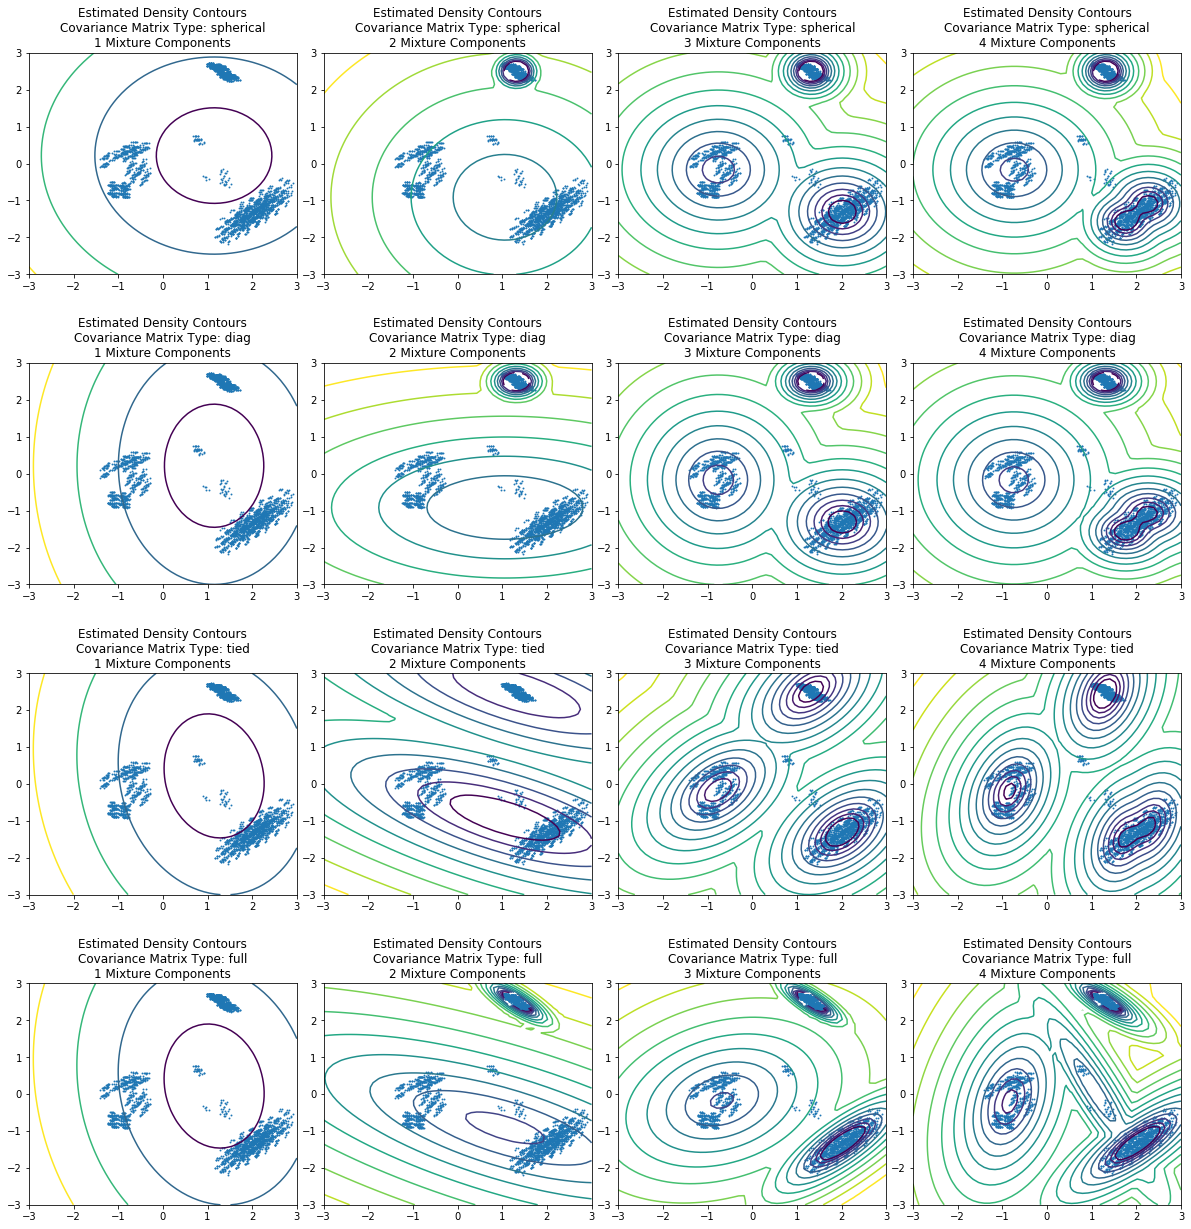

In [7]:
### STUDENT START ###    
    
def plot_gaussian_contours(X, Y, Z, data, ax, n_components, cov_type):
    '''This function plots a single gaussian contour plot
    '''
    CS = ax.contour(
        X, Y, Z, 
        norm=LogNorm(),
        levels=np.logspace(0, 3, 20)
    )
    ax.scatter(data[:, 0], data[:, 1], .8)
    line1 = 'Estimated Density Contours'
    line2 = '\nCovariance Matrix Type: {}'.format(cov_type)
    line3 = '\n{} Mixture Components'.format(n_components)
    ax.set_title(line1 + line2 + line3)


def P4(data, cov_types, n_components):
    i = 0
    
    # create a subplot to display each example in a new plot
    fig, axes = plt.subplots(4,4,figsize=(16,16))
    fig.subplots_adjust(
        left=0, right=1,
        bottom=0, top=1,
        hspace=0.4, wspace=0.1
    )
    
    # for each covariance type
    for c in cov_types:
        # for each mixture component, n, in [1,4]
        for n in range(n_components):
            # build the GaussianMixture classifier and fit it to the 
            # data
            gmm = GaussianMixture(
                n_components=n+1, 
                covariance_type=c,
                random_state=0
            )
            gmm.fit(data)
            
            # build the parameters for the contour plot
            x = np.linspace(-3., 3.)
            y = np.linspace(-3., 3.)
            X, Y = np.meshgrid(x, y)
            XX = np.array([X.ravel(), Y.ravel()]).T
            Z = -gmm.score_samples(XX)
            Z = Z.reshape(X.shape)
            
            # determine the indices of the axis we want to plot on
            ix, iy = np.unravel_index(i, axes.shape)
            ax = axes[ix,iy]
            
            # plot the gaussian contour for the instance
            plot_gaussian_contours(X, Y, Z, data, ax, n+1, c)
            i += 1

cov_types = ['spherical', 'diag', 'tied', 'full']
n_components = 4
data = train_data_2D[train_labels == 1,:]
P4(data, cov_types, n_components)
### STUDENT END ###

## Classify the data

Fit a 4-component GMM to the positive examples, then to the negative examples, then classify by assigning the label that whose fitted model has the largest log-likelihood score.

In [8]:
### STUDENT START ###
def P5(
    pca_components=2, gmm_components=4,
    train_data=train_data, test_data=test_data, 
    train_labels=train_labels, test_labels=test_labels,
):
    
    # Build my PCA dimension reducer, train it on the training data and 
    # project the training data into 2-Dimensions
    pca = PCA(n_components=pca_components, random_state=0)
    train_data_2D = pca.fit(train_data).transform(train_data)
    
    # project the test data into 2-dimensions using the the PCA we built
    test_data_2D = pca.transform(test_data)
    
    # separate the positive and negative examples out of the training 
    # data
    p = train_data_2D[train_labels == 1, :]
    n = train_data_2D[train_labels == 0, :]
    
    # Build a Gaussian Mixture classifier
    gmm = GaussianMixture(
        n_components=gmm_components, 
        covariance_type='full',
        random_state=0
    )
    
    # fit the GMM to the positive examples in the 2D training data and 
    # collect the log-likelihood scores for each sample in the
    # 2-dimensional test data
    gmm.fit(p)
    scores1 = gmm.score_samples(test_data_2D)
    
    # fit the GMM to the negative examples in the 2D training data and 
    # collect the log-likelihood scores for each sample in the
    # 2-dimensional test data
    gmm.fit(n)
    scores2 = gmm.score_samples(test_data_2D)
    
    # predict the label of the 2D test data by choosing the label with 
    # the higher log-likelihood between the two GMM models
    pred = scores1 > scores2
    
    # determine the accuracy using this prediction method
    accuracy = 1. * len(pred[pred == test_labels]) / len(test_labels)
    print 'Accuracy of PCA-GMM pipeline = ', accuracy
    
    return pred, accuracy

pred, accuracy = P5()
### STUDENT END ###

Accuracy of PCA-GMM pipeline =  0.950177935943


## Improve the accuracy

Using a pseudo grid search implementation, find the GMM model with the highest accuracy and no more than 50 parameters. See `num_params` docstring for parameter determination

In [9]:
### STUDENT START ###

def num_params(pca, gmm, test_labels):
    '''This function calculates the number of parameters in the entire 
    pipeline. The number of features in the GMM is equal to the number 
    of PCA components we set. The number of covariance matrices used
    depends on the covariance type we set. The total number of 
    parameters will vary based on covariance matrix type. The number of 
    classes will always be 2 for this dataset, since we either 
    have 'poisonous' or 'non-poisonous'
    
    For covariance_type = 'full', each PCA component uses its own 
    fully defined covariance matrix, so the number of covariance 
    matrix parameters = (number of PCA components)^2 and therefore total
    number of parameters = ((num_PCA_components + num_PCA_components^2) 
    * num_GMM_components) * num_classes
    
    For covariance_type = 'diag', each feature uses its own diagonal 
    covariance matrix, so the number of covariance matrix parameters = 
    number of PCA components. Therefore total
    number of parameters = ((num_PCA_components + num_PCA_components) 
    * num_GMM_components) * num_classes
    
    For covariance_type = 'tied', each feature uses a single fully 
    defined covariance matrix, so the number of covariance matrix 
    parameters = (number of PCA components)^2. However, we do not
    multiply this value by the number of GMM components since each 
    GMM component uses the same cov matrix. Therefore total
    number of parameters = ((num_PCA_components * num_GMM_components) +
    num_PCA_components^2) * num_classes
    
    For covariance_type = 'spherical', each GMM component uses its own
    single variance value, so the number of covariance 
    matrix parameters = number of GMM components. Therefore total number
    of parameters = ((num_PCA_components * num_GMM_components) + 
    num_GMM_components) * num_classes
    '''
    
    # get the number of PCA components, the number of GMM components and
    # the covariance type
    n_pca = pca.n_components
    n_gmm = gmm.n_components
    n_classes = len(np.unique(test_labels))
    cov_type = gmm.covariance_type
    
    # calculate the total number of parameters using the logic in the 
    # docstring
    if cov_type is "full":
        params = ((n_pca + n_pca**2) * n_gmm) * n_classes
    elif cov_type is "diag":
        params = ((n_pca + n_pca) * n_gmm) * n_classes
    elif cov_type is "tied":
        params = ((n_pca * n_gmm) + n_pca**2) * n_classes
    elif cov_type is "spherical":
        params = ((n_pca * n_gmm) + n_gmm) * n_classes
    
    return params

def P6(
    n_components, 
    train_data=train_data, train_labels=train_labels, 
    test_data=test_data, test_labels=test_labels
):
    # set the allowed types of covariance matrices
    cov_types = ['full', 'diag', 'tied', 'spherical']
    
    data_list = []
    for i in n_components:
        # build a PCA dimensionality reducer using i number of 
        # components
        pca = PCA(n_components=i, random_state=0)
        
        # fit the training data and reduce it to i dimensions
        data = pca.fit(train_data).transform(train_data)
        
        # project the test data down to i dimensions
        test = pca.transform(test_data)
        
        # split the training data into 'poisonous' and 'non-poisonous'
        p = data[train_labels == 1, :]
        n = data[train_labels == 0, :]
        for j in n_components:
            for cov in cov_types:
                # build a GMM with j number of components and 
                # covariance_type = cov
                gmm = GaussianMixture(
                    n_components=j, 
                    covariance_type=cov,
                    random_state=0
                )
                
                # calculate the number of parameters
                params = num_params(pca, gmm, test_labels)
                
                # throw out any model that uses greater than 50 
                # parameters
                if params > 50:
                    continue
                
                # fit the GMM to the poisonous data
                gmm.fit(p)
                
                # get the log-likelihood scores for the test data
                scores1 = gmm.score_samples(test)
                
                # fit the GMM to the non-poisonous data
                gmm.fit(n)
                
                # get the log-likelihood scores for the test data
                scores2 = gmm.score_samples(test)
                
                # predict the label of the test data by choosing the 
                # model which has the higher log-likelihood for that 
                # data point
                pred = scores1 > scores2
                
                # determine the accuracy using this prediction method
                accuracy = 1. * len(pred[pred == test_labels]) / len(pred)
                data_list.append([i,j,cov,params,accuracy])

    df = pd.DataFrame(data_list, columns=[
        'PCA_components', 'GMM_components', 
        'Covariance_Type', 'Num_Params', 'Accuracy'
    ])
    df = df.sort_values(by='Accuracy', ascending=False)
    print df.head(10)
    print '\nBEST MODEL:'
    print 'Number of PCA Components: ', df.PCA_components.iloc[0]
    print 'Number of GMM Components: ', df.GMM_components.iloc[0]
    print 'GMM Covariance Type: ', df.Covariance_Type.iloc[0]
    print 'Total No. of Parameters: ', df.Num_Params.iloc[0]
    print 'Model Accuracy: ', df.Accuracy.iloc[0]
    
    return df

n_components = range(1,25)
df = P6(n_components)

### STUDENT END ###

     PCA_components  GMM_components Covariance_Type  Num_Params  Accuracy
130               7               3       spherical          48  0.973310
126               6               3       spherical          42  0.967972
121               5               4       spherical          48  0.967972
120               5               3       spherical          36  0.966192
103               3               5       spherical          40  0.961744
101               3               4       spherical          32  0.959964
114               4               4       spherical          40  0.957295
87                2              10            tied          48  0.957295
104               3               6       spherical          48  0.955516
99                3               4            diag          48  0.955516

BEST MODEL:
Number of PCA Components:  7
Number of GMM Components:  3
GMM Covariance Type:  spherical
Total No. of Parameters:  48
Model Accuracy:  0.9733096085409253
